In [1]:
# first we import all relevant packages
from bulk import * # bulk.py stores a lot of my personal functions, i.e. for reading from the .data files and such
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pynbody
from scipy import stats
from scipy.stats import binned_statistic


In [2]:
# we set the global matplotlib parameters so the fonts are all consistent and serif 
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['figure.constrained_layout.use'] = True
mpl.rcParams.update({'font.size': 9})

## Setup

Here we define a few functions that we will make use of later on. One is for the [Wilson Score Interval](https://en.wikipedia.org/?title=Wilson_score_interval&redirect=no), the other is simply to define which satellites are quenched based on their specific star formation rate (sSFR). 

In [3]:
# wilson score interval is used to calculate error in fractional quantities
def WilsonScoreInterval(z,p,M):
    return (1/(1+(z**2)/M)) * (p + ((z**2)/(2*M)) + z * np.sqrt((p*(1-p)/M) + (z**2)/(4*M**2)))

# definition of "quenched"
def quenched(data):
    return np.array(data.sSFR < 1e-11, dtype=bool)

Now we need to load in the data from the McConnachie (2012) paper. Our goal here is to get Quenched Fraction as a function of stellar mass for satellites of the MW and satellites of M31. 

These data were downloaded from SIMBAD and represent the full catalog described in McConnachie (2012). For these LG satellites, we are only given information about their atomic hydrogen content $M_{HI}/M_*$. Thus, we infer whether they are quenched from this parameter. Wetzel et al. (2015) define a quenched satellite as one with $M_{HI}/M_* < 0.1$. We use a threshold of 0.2 since this is more consistent with our sSFR threshold (see Akins et al. 2020). 

In [4]:
# load in the McConnachie2012Data.csv file which I downloaded from SIMBAD
mcconnachie = pd.read_csv('McConnachie2012Data.csv')

MW = mcconnachie[(mcconnachie.SubG=='MW')&(mcconnachie.DMW < 300)] # select MW satellites
M31 = mcconnachie[(mcconnachie.SubG=='M31')&(mcconnachie.DM31 < 300)] # select M31 satellites
M31 = M31[M31.Name != "Triangulum"] # remove Triangulum since it doesn't have enough info

# Combhine the two into one dataset
All = MW.append(M31) 

# define quenched as mHI/Mstar < 0.2, or mHI is nan, since that means HI is undetected ("|" means "or")
q = np.array((All.mHI / All.Mstar < 0.2) | np.isnan(All.mHI),dtype=bool)
mstar = np.log10(All.Mstar*1e6)
bins = np.arange(3,11,1)
y1, binEdges = np.histogram(mstar, bins=bins) # histogram of satellite masses
y2, binEdges = np.histogram(mstar[q], bins=bins) # histogram of *quenched* satellite masses
bc_Mc = 0.5*(binEdges[1:]+binEdges[:-1]) # bincenters
All_Mc = y2/y1 # quenched fraction of all McConnachie satellites
All_N_Mc = y1 # Number of satellites in each bin (for error calculation)

# Figure 3 (quenched fraction vs. stellar mass)

Quenched fractions for Justice League satellites in 1 dex bins of stellar mass. Individual simulations are indicated with points of varying shape, while the solid line represents the total for all four simulations. All simulated data are limited to galaxies with more than 100 star particles, and error bars represent 68% uncertainty in the binomial proportion via the Wilson Score Interval. Observational data from Geha et al. (2017, G+17), McConnachie (2012, M12), Weisz et al. (2015, W+15), and Karachentsev et al. (2013, K+13, as compiled by Weisz) are presented for comparison. Shaded regions represent the given uncertainty in observed quenched fractions. Our data generally agree with observations of the Local Group and other nearby galaxies, and a relationship between quenched fraction and galaxy mass is apparent.

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


5.399210033013597
5.660191793017641
5.497872519491747
5.415931644845319


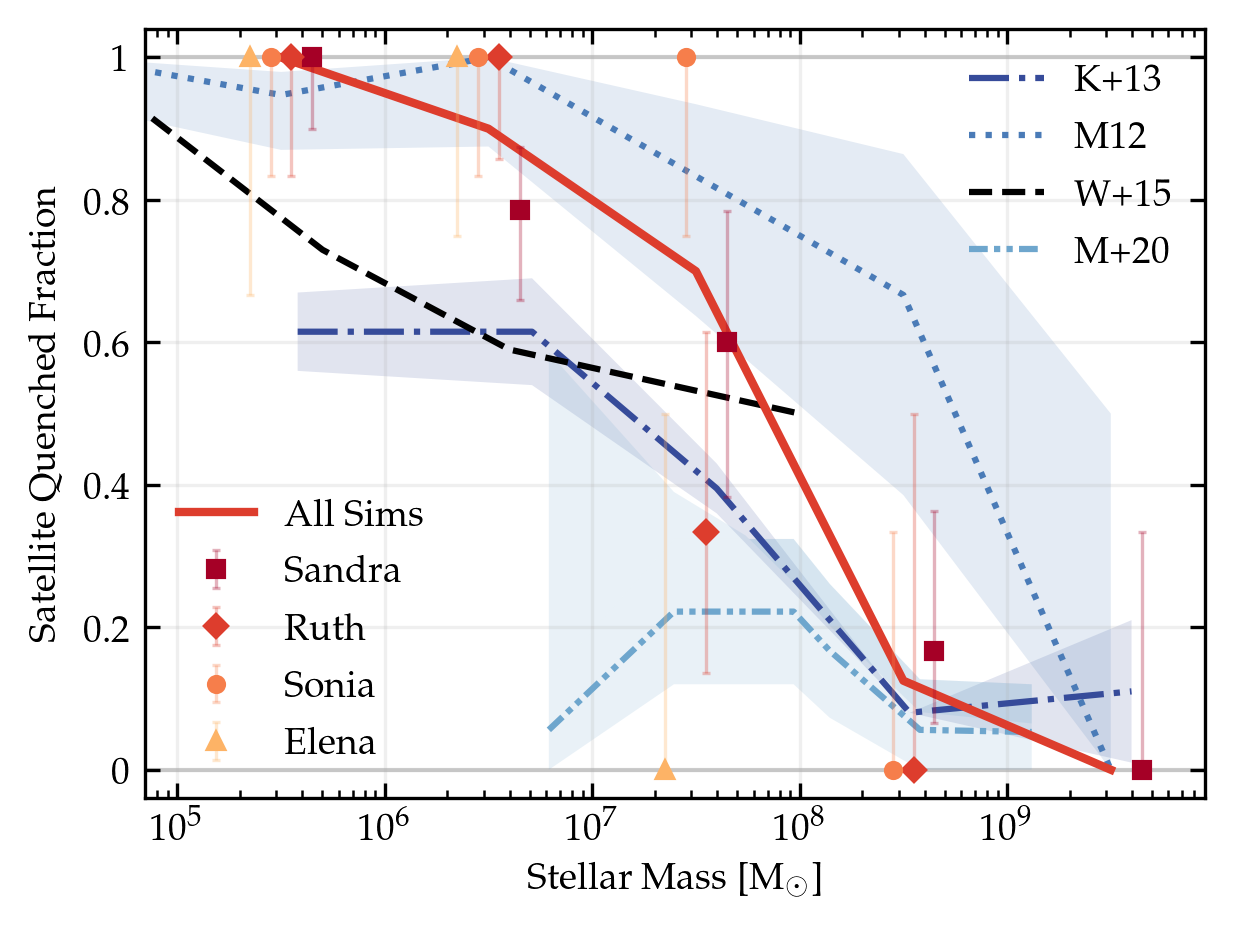

In [11]:
# load in the data and clean up 
data = read_sat() # function defined in bulk.py
data = data[data['n_star']>50] # limit analysis to "resolved" halos w/ more than 100 star particles

# limit sample to just satellites, defined as those within 300 kpc of their host (i.e. directly comparable to LG observations)
dist, vir = distance_to_nearest_host(data) # function defined in bulk.py
s = dist/vir < 1  # define satellites as those where dist < 300
s = s[dist!=0] # remove from the satellite array the four host halos

# make arrays for the quantities of interest: mass and whether the satellite is quenched
mass = np.log10(np.array(data.M_star, dtype=float))[dist!=0]
q = quenched(data)[dist!=0]
dist = dist[dist!=0]

# set up import plotting stuff
nbins = 5
colors = ['#A50026','#DD3D2D', '#F67E4B', '#FDB366']
obs_colors = ['#364B9A', '#4A7BB7', '#6EA6CD', '#98CAE1'] 
offsets = np.array([-0.15,-0.05,0.05,0.15]) # how far the indiv. simulation points are offset from the bin center (for visibility)

# initialize the figure
fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=300,sharex=True)

# first, plot the aggregate for all sims
bin_edges = np.arange(3,11,1)
y2, binEdges2 = np.histogram(mass[s],bins=bin_edges) # histogram of satellite masses 
y1, binEdges1 = np.histogram(mass[q & s], bins=bin_edges) # histogram of quenched satellite masses
bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])
p, = ax.plot(10**bincenters, y1/y2, '-', color='#DD3D2D', linewidth=2, zorder=20)
sim_plots = [p]
sim_labels = ['All Sims']

# add Karachentsev et al (2013) observational data compiled by Weisz (2015) (data from table)
bincenters = np.array([5.58,6.71,7.6,8.53,9.6])
y1 = np.array([0.56,0.54,0.36,0.08,0.21])
y2 = np.array([0.67,0.69,0.43,0.08,0.01])
ax.fill_between(10**bincenters, y1, y2, fc=obs_colors[0], ec='none', alpha=0.15, lw=0.5)
p, = ax.plot(10**bincenters, (y1+y2)/2, '-.', color=obs_colors[0], markersize=2.5, linewidth=1.5)
obs_plots = [p]
obs_labels = ['K+13']

# add McConnachie (2012) data as seen in Wetzel (2015) observational data (data compiled from .csv earlier in notebook)
yerr_lower = All_Mc - WilsonScoreInterval(-1,All_Mc,All_N_Mc)
yerr_upper = WilsonScoreInterval(1,All_Mc,All_N_Mc)-All_Mc
p, = ax.plot(10**bc_Mc[1:], All_Mc[1:], ':', color=obs_colors[1], markersize=2.5, linewidth=1.5)
obs_plots.append(p)
obs_labels.append('M12')
ax.fill_between(10**bc_Mc[1:], All_Mc[1:] - yerr_lower[1:], All_Mc[1:] + yerr_upper[1:], 
               fc = obs_colors[1], ec='none', alpha=0.15, lw=0.5)

# add Weisz et al (2015) observational data (data from table)
bincenters = np.array([4.5,5.7,6.6,8.0])
y = np.array([1,0.73,0.59,0.5])
p, = ax.plot(10**bincenters, y, '--', color='k', markersize=2.5, linewidth=1.5)
obs_plots.append(p)
obs_labels.append('W+15')


# add Mao et al. (2020) data (SAGA) (from email)    
bincenters = np.array([6.791,7.394,7.739,7.971,8.145,8.580,9.119])
y = np.array([0.056,0.222,0.222,0.222,0.167,0.056,0.053])
SAGA_lower = y - np.array([0.056,0.102,0.102,0.102,0.094,0.056,0.053])
SAGA_upper = y + np.array([0.071,0.102,0.102,0.102,0.094,0.071,0.067])
SAGA_incomplete = y + np.array([0.530,0.168,0.107,0.041,0.035,0.025,0.012])

p, = ax.plot(10**bincenters,y, linestyle=(0, (3, 1, 1, 1, 1, 1)), color=obs_colors[-2], linewidth=1.5)
ax.fill_between(10**bincenters, SAGA_lower, SAGA_upper, fc=obs_colors[-2], ec='none', alpha=0.15, lw=0.5)
ax.fill_between(10**bincenters, SAGA_upper, SAGA_incomplete, fc=obs_colors[-2], ec='none', alpha=0.15, lw=0.5)
obs_plots.append(p)
obs_labels.append('M+20')


# Now, plot the QFs for the individual simulations
for name,label,color,mark,off in zip(['h148','h229','h242','h329'],['Sandra','Ruth','Sonia','Elena'],colors,['s','D','o','^'],offsets):
    data = read_file(name)
    data = data[data['n_star']>50]

    # load in distance to nearest host
    dist, vir = distance_to_nearest_host(data)
    s = dist < 300 # define satellites as those where dist < 300 kpc
    s = s[dist!=0]
    
    mass = np.log10(np.array(data.M_star, dtype=float))[dist!=0]
    q = quenched(data)[dist!=0]
    dist = dist[dist!=0]
    
    print(np.min(mass))
    
    bin_edges = np.arange(5,11)
    y2, binEdges2 = np.histogram(mass,bins=bin_edges)
    bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
    y1, binEdges1 = np.histogram(mass[q],bins=bin_edges)
    bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])

    p = y1/y2
    M = y2

    markers, caps, bars = ax.errorbar(10**(bincenters-off),WilsonScoreInterval(0,p,M), 
                                      yerr=np.array([p - WilsonScoreInterval(-1,p,M), WilsonScoreInterval(1,p,M) - p]),
                                      color=color,
                                      marker=mark,
                                      ms=np.sqrt(13), 
                                      linestyle='none', 
                                      linewidth=2,
                                      ecolor=color,
                                      elinewidth=0.8, 
                                      capsize=1,
                                      capthick=0.8,
                                      clip_on=False,
                                      alpha = 1,
                                      zorder=105)
    
    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.3) for bar in bars]
    [cap.set_alpha(0.3) for cap in caps]
    
    sim_plots.append(mpl.container.ErrorbarContainer((markers, caps, bars), has_yerr=True))
    sim_labels.append(label)


ax.plot([1e3,1e12],[0,0],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
ax.plot([1e3,1e12],[1,1],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
    
# labels and limits
ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Satellite Quenched Fraction')
ax.set_ylim(-0.04,1.04)
ax.set_xlim(7e4,9e9)
ax.grid(alpha=0.2)

# legend and ticks
leg1 = ax.legend(sim_plots, sim_labels, prop={'size':9},frameon=False, loc='lower left')
leg2 = ax.legend(obs_plots, obs_labels, prop={'size':9},frameon=False, loc='upper right')
ax.add_artist(leg1)

ax.semilogx()
ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_yticklabels([None,0,0.2,0.4,0.6,0.8,1])

# save and show
plt.savefig('QF_updatedSAGA.pdf')
plt.show()


In [17]:
# add Geha et al. (2017) data (SAGA)
SAGA1 = pd.read_csv('SAGA_data_cleaned.csv')
SAGA1 = SAGA1[SAGA1.M_r < -12.3] # remove those galaxies below the limit for full detection

print(len(SAGA1))
SAGA1.keys()

45


Index(['name', 'sdss_objid', 'ra', 'dec', 'r_o', 'M_r', 'g-r_o', 'mu_r',
       'r_proj', 'halpha', 'v-v_host', 'tel', 'complete'],
      dtype='object')

In [29]:
SAGA = pd.read_csv('saga_stage2_sats.csv')
SAGA = SAGA[SAGA.R_ABS < -12.3]
print(f'There are N = {len(SAGA)} satellites in the SAGA dataset (should be 123)')
print(f'Minimum mass {np.min(SAGA.LOG_STELLAR_MASS):.2e}')
print(f"There are N = {len(SAGA[SAGA.H_ALPHA=='N'])} quenched galaxies (should be 18)")
print(SAGA2.keys())

There are N = 123 satellites in the SAGA dataset (should be 123)
Minimum mass 6.51e+00
There are N = 18 quenched galaxies (should be 18)
Index(['HOST_COMMON_NAME', 'OBJID', 'RA', 'DEC', 'D_PROJ', 'DELTA_HRV', 'R',
       'R_ABS', 'GR', 'MU_EFF', 'LOG_STELLAR_MASS', 'H_ALPHA', 'Z_SOURCE',
       'INTERNAL_HOSTID', 'INTERNAL_OBJID'],
      dtype='object')


In [5]:
Mr_sol = 4.65 # solar magnitude in SDSS r-band
L = 10**((Mr_sol - np.array(SAGA.M_r))/2.5) # convert SAGA r-band mags to luminosities in Lsol.

M_per_L = 1.66
# M_per_L = 2.6791729093269607 # mass-to-light ratio from Elaad's M_r calculations
# M_per_L = 1
mass = np.log10(M_per_L*L) # assume Mass-to-light ratio of 1, so we have our mass in Msol

SAGA['log10mstar'] = mass
print(f'{np.min(SAGA.log10mstar):.2e}')
print(len(mass[SAGA.halpha=='N']))

45
7.04e+00
1


In [14]:
SAGA.keys()

Index(['name', 'sdss_objid', 'ra', 'dec', 'r_o', 'M_r', 'g-r_o', 'mu_r',
       'r_proj', 'halpha', 'v-v_host', 'tel', 'complete', 'log10mstar'],
      dtype='object')

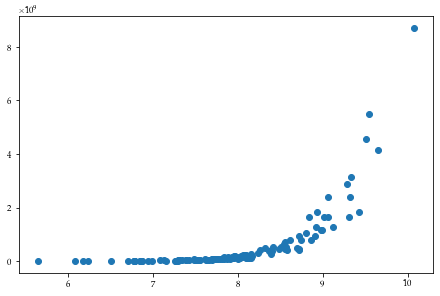

Signature: np.polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
Docstring:
Least squares polynomial fit.

Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
to points `(x, y)`. Returns a vector of coefficients `p` that minimises
the squared error in the order `deg`, `deg-1`, ... `0`.

The `Polynomial.fit <numpy.polynomial.polynomial.Polynomial.fit>` class
method is recommended for new code as it is more stable numerically. See
the documentation of the method for more information.

Parameters
----------
x : array_like, shape (M,)
    x-coordinates of the M sample points ``(x[i], y[i])``.
y : array_like, shape (M,) or (M, K)
    y-coordinates of the sample points. Several data sets of sample
    points sharing the same x-coordinates can be fitted at once by
    passing in a 2D-array that contains one dataset per column.
deg : int
    Degree of the fitting polynomial
rcond : float, optional
    Relative condition number of the fit. Singular values smaller

In [12]:
SAGA2 = pd.read_csv('saga_stage2_sats.csv')

M_r = np.array(SAGA2.R_ABS)
g_r = np.array(SAGA2.GR)

M_star = 10**(1.254 + 1.098 * g_r - 0.4 * M_r)

In [11]:
data = read_sat()
data = data[data.haloid==1]
data[['sim','Rvir']]

,sim,Rvir
0,h148,432.304078
0,h229,339.754971
0,h242,333.291880
0,h329,292.536039


In [ ]:
v

-5.8874029547523365
-5.8874029547523365 -1.9308218962067665
-5.348605244405913
-5.348605244405913 -2.0883181889399007
-5.455123930343704
-5.455123930343704 -2.049560172093161
-5.537999412054051
-5.537999412054051 -3.515008871468058


/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


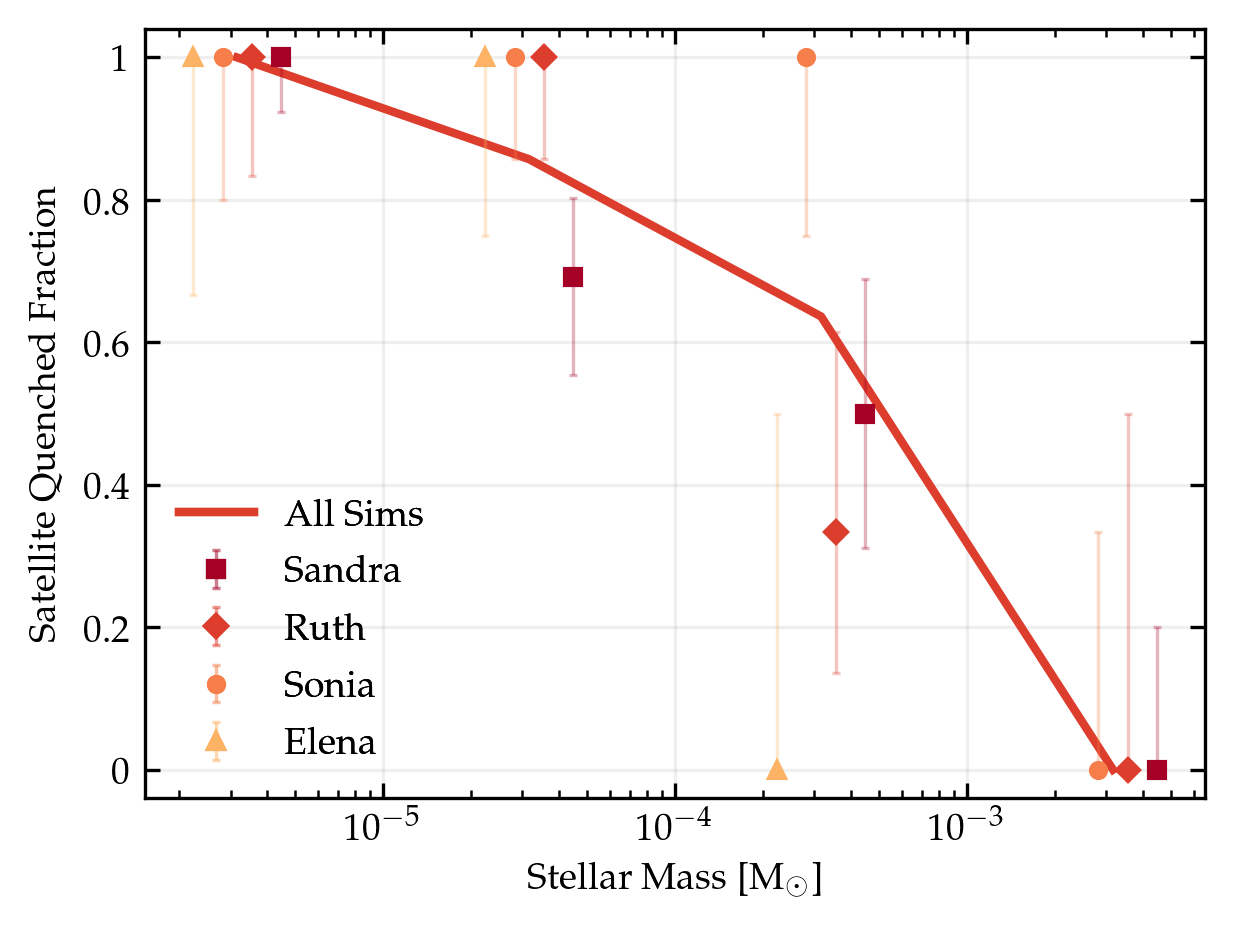

In [14]:
# load in the data and clean up 
data = read_sat() # function defined in bulk.py
data = data[data['n_star']>50] # limit analysis to "resolved" halos w/ more than 100 star particles

# limit sample to just satellites, defined as those within 300 kpc of their host (i.e. directly comparable to LG observations)
dist, vir = distance_to_nearest_host(data) # function defined in bulk.py
s = dist/vir < 1  # define satellites as those where dist < 300
s = s[dist!=0] # remove from the satellite array the four host halos

# make arrays for the quantities of interest: mass and whether the satellite is quenched
hmass = np.zeros(shape=np.shape(data.M_star))
hmass[data.sim=='h148'] = np.array(data.M_star[(data.sim=='h148')&(dist==0)].tolist()[0])
hmass[data.sim=='h229'] = np.array(data.M_star[(data.sim=='h229')&(dist==0)].tolist()[0])
hmass[data.sim=='h242'] = np.array(data.M_star[(data.sim=='h242')&(dist==0)].tolist()[0])
hmass[data.sim=='h329'] = np.array(data.M_star[(data.sim=='h329')&(dist==0)].tolist()[0])
mass = np.log10(np.array(data.M_star,dtype=float)[dist!=0] / hmass[dist != 0])

#mass = np.log10(np.array(data.M_star, dtype=float))[dist!=0]
q = quenched(data)[dist!=0]
dist = dist[dist!=0]

# set up import plotting stuff
nbins = 5
colors = ['#A50026','#DD3D2D', '#F67E4B', '#FDB366']
obs_colors = ['#364B9A', '#4A7BB7', '#6EA6CD', '#98CAE1'] 
offsets = np.array([-0.15,-0.05,0.05,0.15]) # how far the indiv. simulation points are offset from the bin center (for visibility)

# initialize the figure
fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=300,sharex=True)

# first, plot the aggregate for all sims
bin_edges = np.arange(-6,-1,1)
y2, binEdges2 = np.histogram(mass[s],bins=bin_edges) # histogram of satellite masses 
y1, binEdges1 = np.histogram(mass[q & s], bins=bin_edges) # histogram of quenched satellite masses
bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])
p, = ax.plot(10**bincenters, y1/y2, '-', color='#DD3D2D', linewidth=2, zorder=20)
sim_plots = [p]
sim_labels = ['All Sims']


# Now, plot the QFs for the individual simulations
for name,label,color,mark,off in zip(['h148','h229','h242','h329'],['Sandra','Ruth','Sonia','Elena'],colors,['s','D','o','^'],offsets):
    data = read_file(name)
    data = data[data['n_star']>50]

    # load in distance to nearest host
    dist, vir = distance_to_nearest_host(data)
    s = dist < 300 # define satellites as those where dist < 300 kpc
    s = s[dist!=0]
    
    mass = np.log10(np.array(data.M_star, dtype=float)[dist!=0] / np.array(data.M_star,dtype=float)[dist==0])
    q = quenched(data)[dist!=0]
    dist = dist[dist!=0]
    
    print(np.min(mass))
    
    bin_edges = np.arange(-6,-1)
    y2, binEdges2 = np.histogram(mass,bins=bin_edges)
    bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
    y1, binEdges1 = np.histogram(mass[q],bins=bin_edges)
    bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])

    p = y1/y2
    M = y2
    
    print(np.min(mass), np.max(mass))

    markers, caps, bars = ax.errorbar(10**(bincenters-off),WilsonScoreInterval(0,p,M), 
                                      yerr=np.array([p - WilsonScoreInterval(-1,p,M), WilsonScoreInterval(1,p,M) - p]),
                                      color=color,
                                      marker=mark,
                                      ms=np.sqrt(13), 
                                      linestyle='none', 
                                      linewidth=2,
                                      ecolor=color,
                                      elinewidth=0.8, 
                                      capsize=1,
                                      capthick=0.8,
                                      clip_on=False,
                                      alpha = 1,
                                      zorder=105)
    
    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.3) for bar in bars]
    [cap.set_alpha(0.3) for cap in caps]
    
    sim_plots.append(mpl.container.ErrorbarContainer((markers, caps, bars), has_yerr=True))
    sim_labels.append(label)


#ax.plot([1e3,1e12],[0,0],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
#ax.plot([1e3,1e12],[1,1],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
    
# labels and limits
ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Satellite Quenched Fraction')
ax.set_ylim(-0.04,1.04)
#ax.set_xlim(7e4,9e9)
ax.grid(alpha=0.2)

# legend and ticks
leg1 = ax.legend(sim_plots, sim_labels, prop={'size':9},frameon=False, loc='lower left')
# leg2 = ax.legend(obs_plots, obs_labels, prop={'size':9},frameon=False, loc='upper right')
ax.add_artist(leg1)

ax.semilogx()
ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_yticklabels([None,0,0.2,0.4,0.6,0.8,1])

# save and show
# plt.savefig('QF_M-to-L_1.66.pdf')
plt.show()
